<a href="https://colab.research.google.com/github/mohammadkaifee/Book_Recomendation_System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Book Recommendation System*

##About this Project
This is a Unsupervised Machine Learning Capstone Project, which is part of AlmaBetter's Data Science Pro Program Curriculum.

##Problem Statement
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries). Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors.

The main objective is to create a book recommendation system for users.

##Understanding the Data

The Book-Crossing dataset comprises 3 files:

● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

● Ratings

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [5]:
#Importing modules
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import pickle
import operator
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objs as go
import plotly.io as pio
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
books = pd.read_csv('/content/drive/MyDrive/AlmaBatter/Capstone_Projects/Book Recommendation System/data_book_recommendation/Books.csv')
users = pd.read_csv('/content/drive/MyDrive/AlmaBatter/Capstone_Projects/Book Recommendation System/data_book_recommendation/Users.csv')
ratings = pd.read_csv('/content/drive/MyDrive/AlmaBatter/Capstone_Projects/Book Recommendation System/data_book_recommendation/Ratings.csv')

#*Data Preparation for Exploratory Data Analysis and Visualizations.*

Before we feed the data to our models. First we will try to interpret what the data is trying to convey by extracting necessary information from it using EDA and graphical visualisations.

##*BOOKS*

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
#Shape of Books data
books.shape

(271360, 8)

## *Checking for null values*

In [7]:
def missing_values(df):
    m_val=df.isnull().sum()
    m_val_percent=round(df.isnull().mean().mul(100),2)
    mz_table=pd.concat([m_val,m_val_percent],axis=1)
    mz_table=mz_table.rename(
    columns={df.index.name:'col_name',0:'Missing Values',1:'% of Total Values'})
    mz_table['Data_type']=df.dtypes
    mz_table=mz_table.sort_values('% of Total Values',ascending=False)
    return mz_table.reset_index()

In [8]:
missing_values(books)

,index,Missing Values,% of Total Values,Data_type
0,ISBN,0,0.0,object
1,Book-Title,0,0.0,object
2,Book-Author,1,0.0,object
3,Year-Of-Publication,0,0.0,object
4,Publisher,2,0.0,object
5,Image-URL-S,0,0.0,object
6,Image-URL-M,0,0.0,object
7,Image-URL-L,3,0.0,object


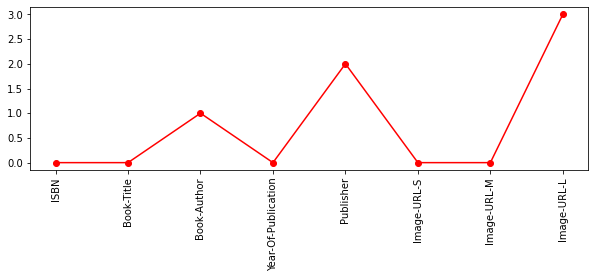

In [9]:
#Graph for null values in books data
a=books.isna().sum()
b=[i for i in a]
plt.figure(figsize=(10,3))
plt.plot(books.columns,b, '-ro')
plt.xticks(rotation = 90)
plt.show()

In [10]:
# Null values in ratings data
missing_values(ratings)

,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,ISBN,0,0.0,object
2,Book-Rating,0,0.0,int64


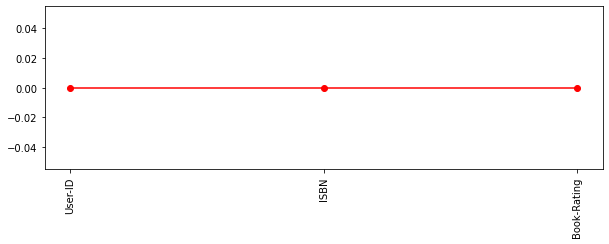

In [11]:
#Graph for null values in ratings data
c=ratings.isna().sum()
d=[i for i in c]
plt.figure(figsize=(10,3))
plt.plot(ratings.columns,d, '-ro')
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Null values in users data
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,Age,110762,39.72,float64
1,User-ID,0,0.00,int64
2,Location,0,0.00,object


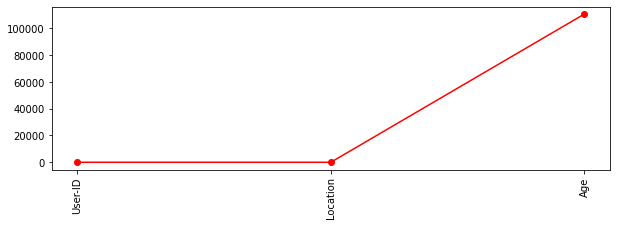

In [13]:
#Graph for null values in users data
e=users.isna().sum()
f=[i for i in e]
plt.figure(figsize=(10,3))
plt.plot(users.columns,f, '-ro')
plt.xticks(rotation = 90)
plt.show()

#*books Dataset Pre-processing*

In [14]:
#Checking Null value of "Book-Author"
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [15]:
#Checking Null value of "Publisher"
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [16]:
#Filling the Null values of "Book-Author" and "Publisher" with other
books.at[187689 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [17]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [18]:
pd.set_option('display.max_colwidth', -1)

In [19]:
#Checking that Book-Author and Year-Of-Publication columns has exchanged for DK Publishing Inc books
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


In [20]:
#Checking that Book-Author and Year-Of-Publication columns has exchanged for Gallimard books
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN


In [21]:
#Seting the correct values for Book-Author and Year-Of-Publication columns that had exchanged for DK Publishing Inc Publisher and Michael Teitelbaum book author
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

#Seting the correct values for Book-Author and Year-Of-Publication columns that had exchanged for DK Publishing Inc Publisher and James Buckley book author
books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

#Seting the correct values for Book-Author and Year-Of-Publication columns that had exchanged for Gallimard Publisher and Jean-Marie Gustave Le ClÃ?Â©zio book author
books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [22]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [23]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [ ]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [24]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [25]:
missing_values(books)

,index,Missing Values,% of Total Values,Data_type
0,ISBN,0,0.0,object
1,Book-Title,0,0.0,object
2,Book-Author,0,0.0,object
3,Year-Of-Publication,0,0.0,int64
4,Publisher,0,0.0,object
5,Image-URL-S,0,0.0,object
6,Image-URL-M,0,0.0,object
7,Image-URL-L,3,0.0,object


In [26]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


#*Users Dataset Pre-processing*

In [27]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [28]:
# shape of users data
users.shape

(278858, 3)

In [29]:
## Checking null values
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,Age,110762,39.72,float64
1,User-ID,0,0.00,int64
2,Location,0,0.00,object


In [30]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

##*Age distribution*

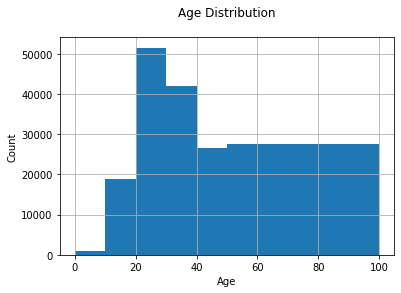

In [31]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The most active users are among those in their 20–30s.

Let's check for outliers in age column

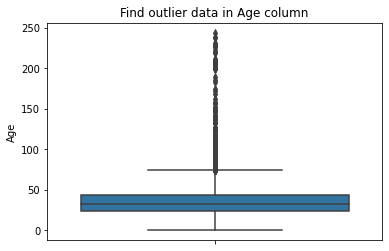

In [32]:
sns.boxplot(y='Age', data=users)
plt.title('Find outlier data in Age column')
plt.show()

##*Let's treat outliers in users age*

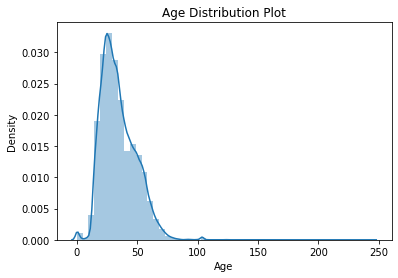

In [33]:
sns.distplot(users.Age)
plt.title('Age Distribution Plot')
plt.show()

Age value's below 5 and above 85 do not make much sense for our book rating case

In [34]:
# data of age between 85 to 5
required = users[users['Age'] <= 85]
required = required[required['Age'] >= 5]

# calculating mean value of Age
mean = round(required['Age'].mean())
mean

35

In [35]:
# Discribing Age Data
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [36]:
#outliers with age grater than 85 are substituted with mean 
users.loc[users['Age'] > 85, 'Age'] = mean

#outliers with age less than 5 years are substitued with mean
users.loc[users['Age'] < 5, 'Age'] = mean

#filling null values with mean
users['Age'] = users['Age'].fillna(mean)

#changing Datatype to int
users['Age'] = users['Age'].astype(int)

In [37]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    #removing invalid entries too
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
      #removing invalid entries 
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    #handling cases where city/state entries from city list as state is already given 
    c = ent.split('/')
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

#printing the number of countries didnt have any values 
print(f"{count_no_country} country's didn't have any value")

#printing the states which didnt have any values
print(f"{count_no_state} state's didn't have any value")

4659 country's didn't have any value
16044 state's didn't have any value


In [38]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [39]:
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,Age,0,0.0,int64
2,City,0,0.0,object
3,State,0,0.0,object
4,Country,0,0.0,object


In [40]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


#*Books-Ratings Dataset Pre-processing*

In [41]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [42]:
#Shape of ratings dataset
ratings.shape

(1149780, 3)

In [43]:
## Checking for null values
missing_values(ratings)

,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,ISBN,0,0.0,object
2,Book-Rating,0,0.0,int64


#*Merging of all three Tables*
###**Merging Books, Users and Rating Tables in One**

In [44]:
df = pd.merge(books, ratings, on='ISBN', how='inner')
df = pd.merge(df, users, on='User-ID', how='inner')
missing_values(df)

,index,Missing Values,% of Total Values,Data_type
0,ISBN,0,0.0,object
1,Book-Title,0,0.0,object
2,Book-Author,0,0.0,object
3,Year-Of-Publication,0,0.0,int64
4,Publisher,0,0.0,object
5,Image-URL-S,0,0.0,object
6,Image-URL-M,0,0.0,object
7,Image-URL-L,4,0.0,object
8,User-ID,0,0.0,int64
9,Book-Rating,0,0.0,int64


In [45]:
## Explicit Ratings Dataset
df1 = df[df['Book-Rating'] != 0]
df1 = df1.reset_index(drop = True)
df1.shape

(383842, 14)

In [46]:
df1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,http://images.amazon.com/images/P/0887841740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0887841740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0887841740.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1552041778.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1552041778.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,http://images.amazon.com/images/P/1567407781.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1567407781.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1567407781.01.LZZZZZZZ.jpg,8,6,35,timmins,ontario,canada


In [47]:
## Implicit Ratings Dataset
df_0 = df[df['Book-Rating'] == 0]
df_0 = df_0.reset_index(drop = True)
df_0.shape

(647294, 14)

In [48]:
df_0.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,2,0,18,stockton,california,usa
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada


#*Data Visualization*

##*Nomber of Books Published per year*

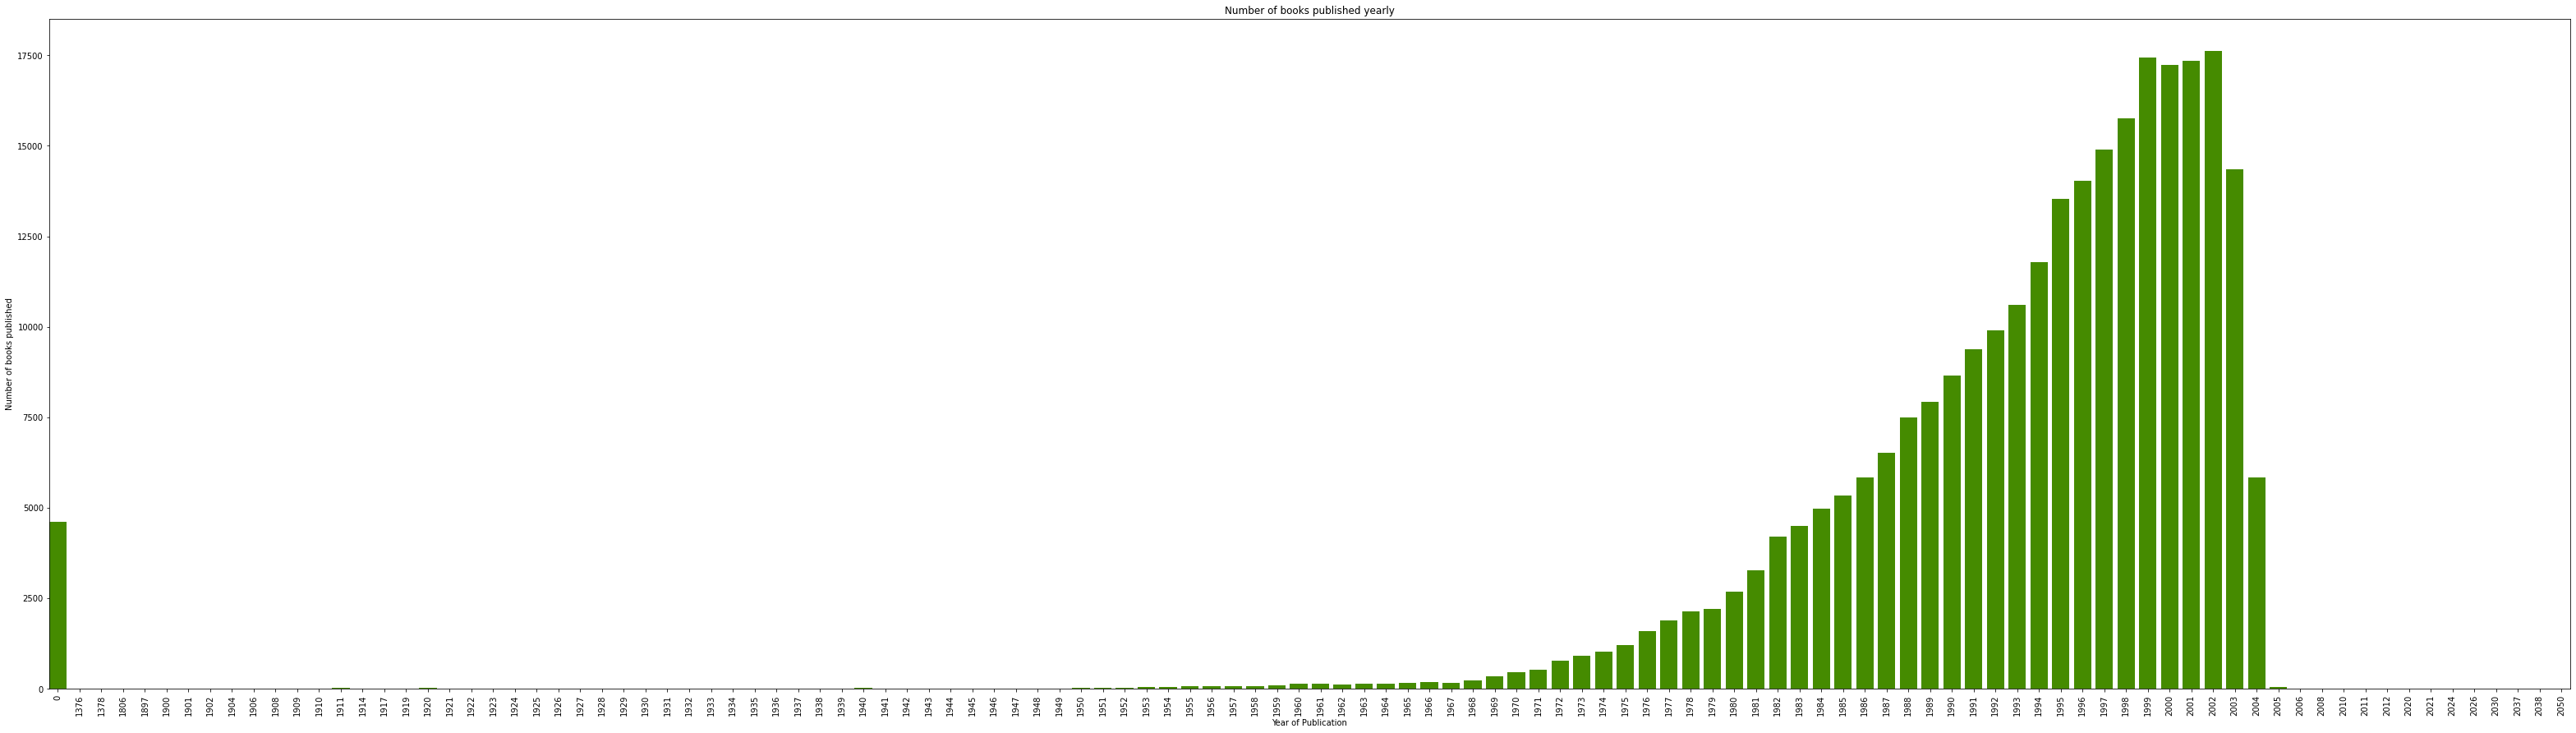

In [49]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = '#458B00')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.xticks(rotation = 90)
plt.margins(x = 0)
plt.show()

##*Top 15 Author's Books*

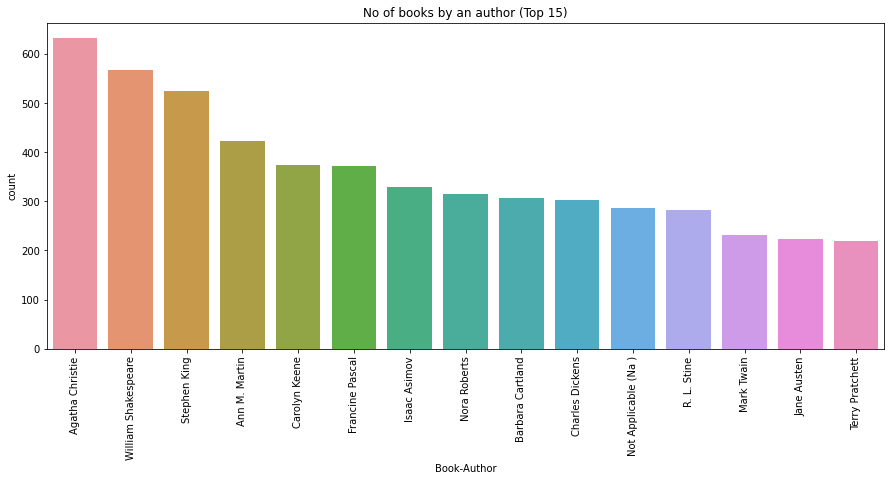

In [50]:
plt.figure(figsize=(15,6))
sns.countplot(x="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.xticks(rotation = 90)
plt.title("No of books by an author (Top 15)")
plt.show()

##*Top 15 Publisher's Books*

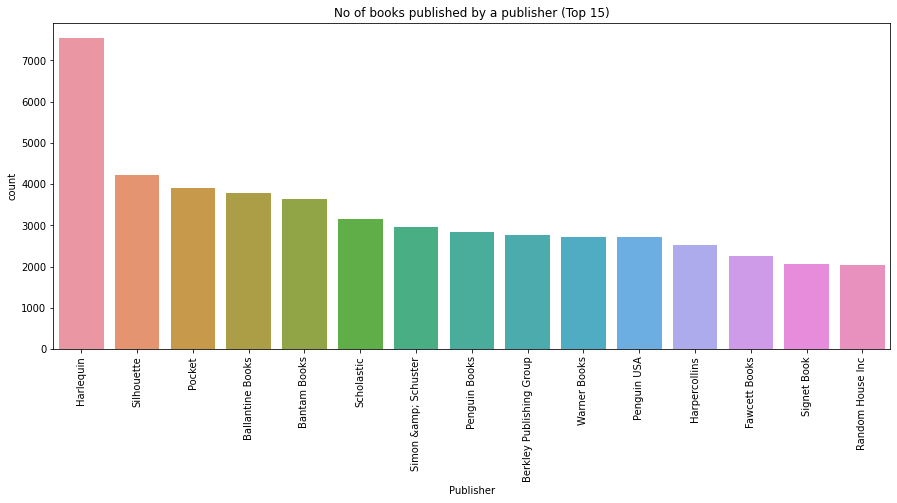

In [51]:
plt.figure(figsize=(15,6))
sns.countplot(x="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.xticks(rotation = 90)
plt.title("No of books published by a publisher (Top 15)")
plt.show()

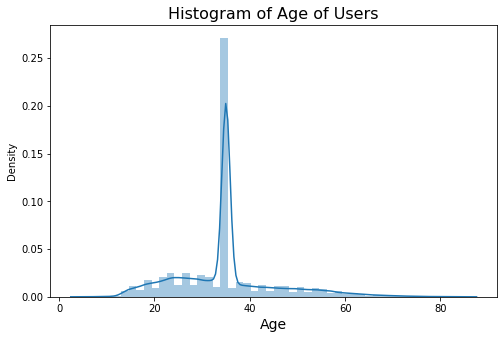

In [52]:
#Plotting distribution of Age data 
fig=plt.figure(figsize=(8,5))
sns.distplot(users['Age'])
plt.xlabel('Age',size=14)
plt.title('Histogram of Age of Users',size=16)
plt.show()

##*Book rating*

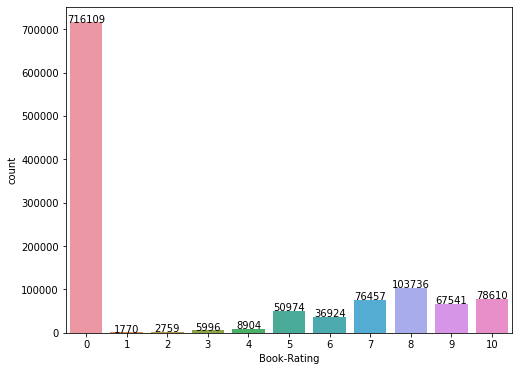

In [53]:
#Book Rating count plot
plt.figure(figsize=(8,6))
ax = sns.countplot(x="Book-Rating", data=ratings)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, ratings['Book-Rating'].value_counts()[i] ,ha="center")

plt.show()

Ratings are of two types, an implicit rating & explicit rating. An implicit rating is based on tracking user interaction with an item such as a user clicking on an item and in this case is recorded as rating '0'. An explicit rating is when a user explicitly rates an item, in this case on a numeric scale of '1-10'

*   Majority of ratings are implicit i.e., rating '0'

*   Rating of '8' has the highest rating count among explicit ratings '1-10'

##*Book rating in ascending order except 0*



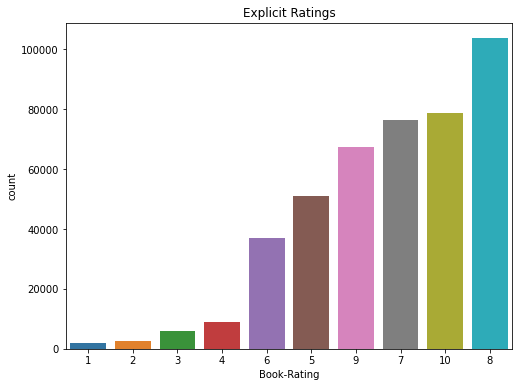

In [54]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data, order=ratings['Book-Rating'].value_counts().sort_values().index[:10])
plt.title("Explicit Ratings")
plt.show()

Most common rating given by users for books is 8

##*Age Count plot*

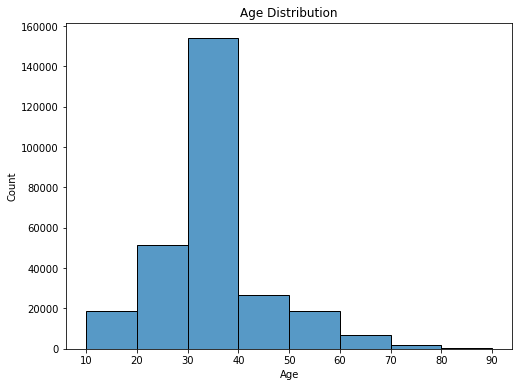

In [55]:
plt.figure(figsize=(8,6))
sns.histplot(users.Age,bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Most number of users are of Age b/w 30 to 40

##*Top 15 City's readors*

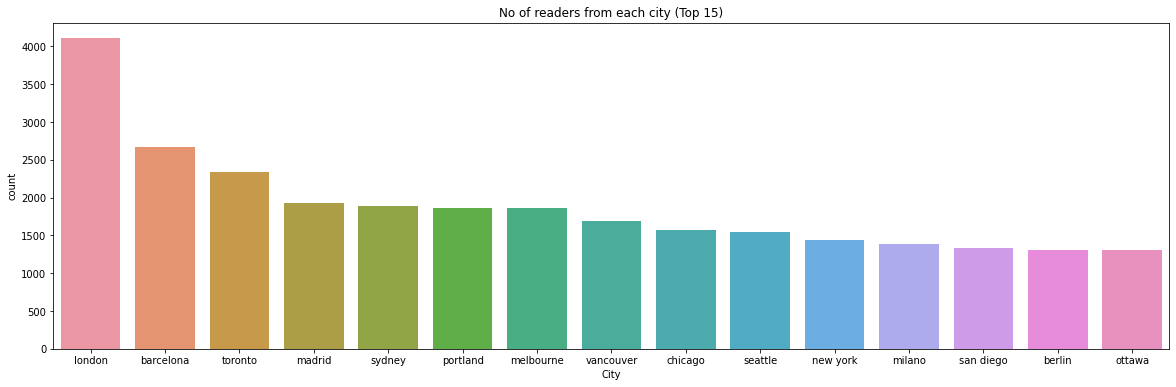

In [56]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")
plt.show()

Most number of users are from London City

##*Top 15 State's readors*

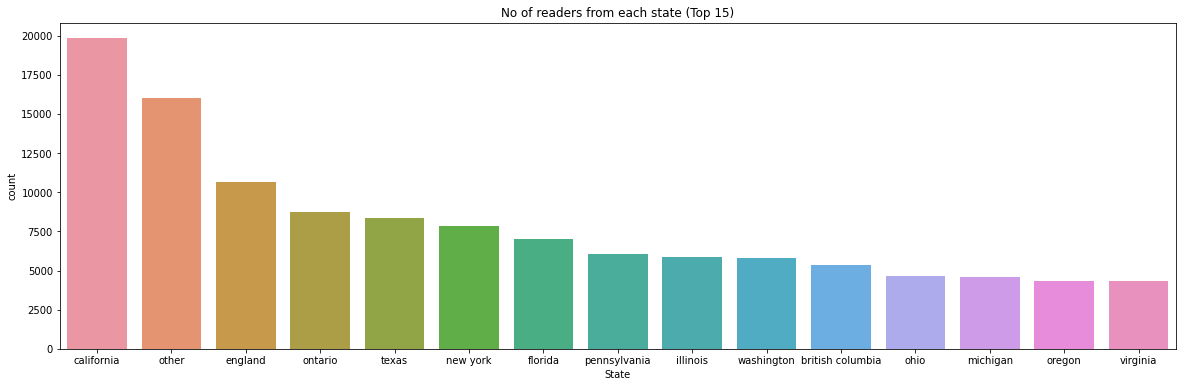

In [57]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")
plt.show()

Most number of users are from California State

##*Top 10 Country's readors*

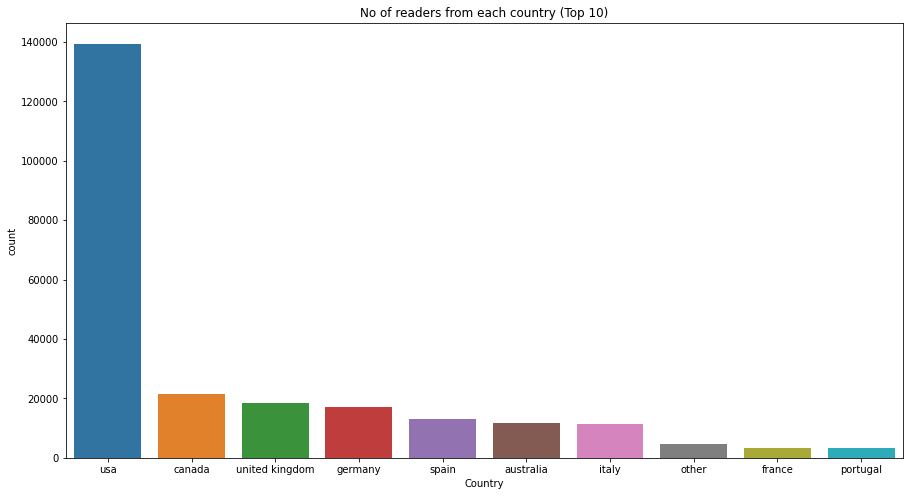

In [58]:
plt.figure(figsize=(15,8))
sns.countplot(x="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")
plt.show()

Most number of users are from USA


##*Readors from top 15 State's of USA*

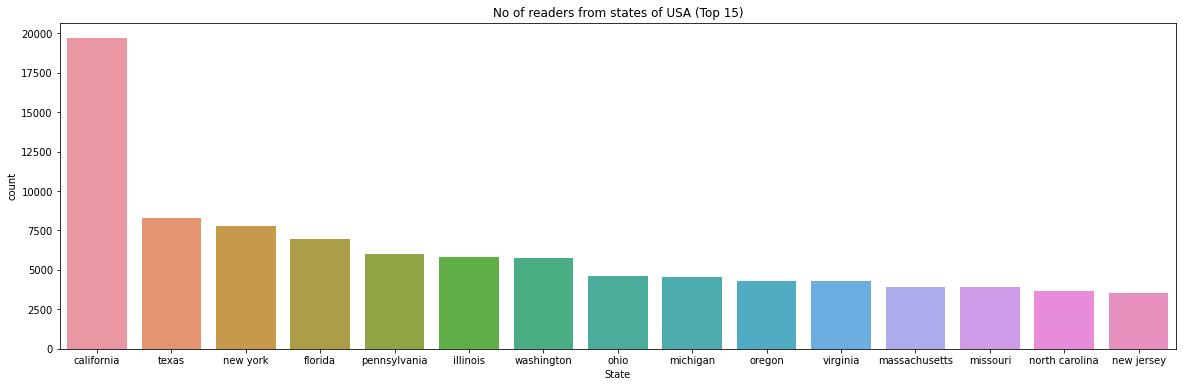

In [59]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")
plt.show()

##*Count of top 15 Book's*

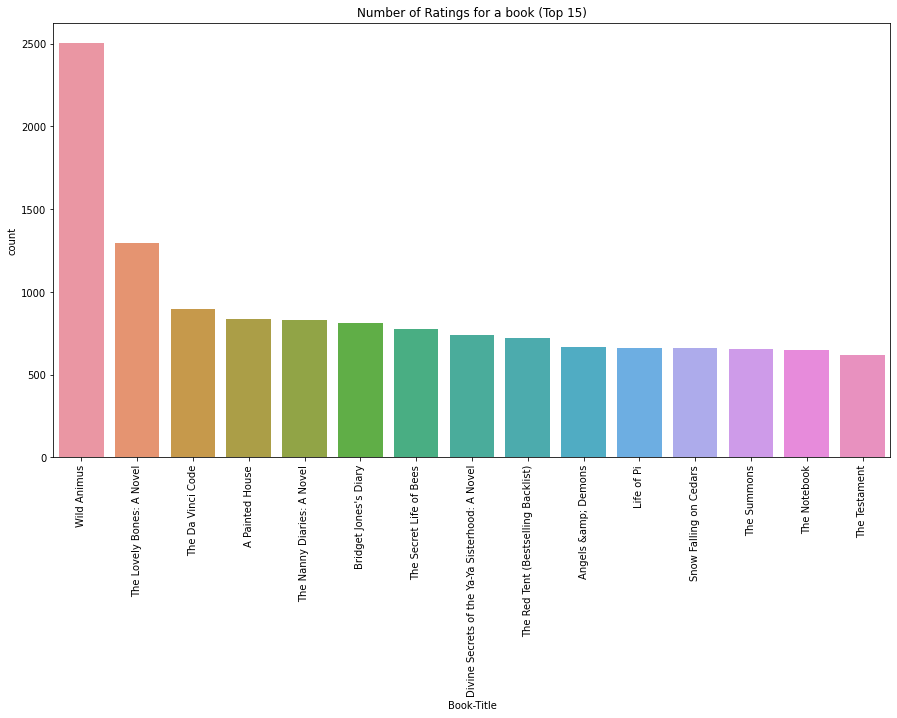

In [60]:
plt.figure(figsize=(15,8))
sns.countplot(x="Book-Title", data=df, order=df['Book-Title'].value_counts().index[0:15])
plt.xticks(rotation = 90)
plt.title("Number of Ratings for a book (Top 15)")
plt.show()

#*Recommendation Systems*

In [61]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Please Enter values Like: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


##*1. Popularity Based Filtering*


As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any book which is usually bought by every new user then there are chances that it may suggest that book to the user who just signed up.

##Book weighted avg formula:

##Weighted Rating*(WR)=[vR/(v+m)]+[mC/(v+m)]*

where,

v is the number of votes for the books;

m is the minimum votes required to be listed in the chart;

R is the average rating of the book; and

C is the mean vote across the whole report.

Now we find the values of v,m,R,C.

In [62]:
# Create column Rating average 
df1['Avg_Rating']=df1.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
df1['Total_No_Of_Users_Rated']=df1.groupby('ISBN')['Book-Rating'].transform('count')
df1.drop(["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis = 1, inplace = True)
df1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country,Avg_Rating,Total_No_Of_Users_Rated
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada,7.666667,9
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada,5.000000,1
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada,5.000000,1
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada,5.000000,1
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada,6.000000,1


In [63]:
C= df1['Avg_Rating'].mean()
m= df1['Total_No_Of_Users_Rated'].quantile(0.90)
Top_Books = df1.loc[df1['Total_No_Of_Users_Rated'] >= m]
print(f'C={C} , m={m}')
Top_Books.shape

C=7.626700569505161 , m=64.0


(38570, 13)

Here we used 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the books in the list.
We see that there are 38478 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, weighted_rating() and define a new feature score, of which we’ll calculate the value by applying this function to our DataFrame of qualified books:

In [64]:
def weighted_rating(x, m=m, C=C):
    v = x['Total_No_Of_Users_Rated']
    R = x['Avg_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
Top_Books['Score'] = Top_Books.apply(weighted_rating,axis=1)
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

In [65]:
#Keeping only one entry of each book
Top_Books=Top_Books.sort_values('Score', ascending=False).drop_duplicates('ISBN').sort_index()
cm=sns.light_palette('yellow',as_cmap=True)
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

#Printing the top 5 books
Top_Books[['Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(5).style.background_gradient(cmap=cm)

,Book-Title,Total_No_Of_Users_Rated,Avg_Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.741835
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313,8.939297,8.716469
2,Harry Potter and the Order of the Phoenix (Book 5),206,9.033981,8.700403
3,To Kill a Mockingbird,214,8.943925,8.640679
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.609690


The Popularity based recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.

##*2. Popularity Based (Top In whole collection)*

In [66]:
# Function for top n Books in dataset on the basis of book rating
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Invalid number of books entered!!"

In [67]:
print(f"Top {number} Popular books are: ")
popularity_based(df1, number)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
2,0385504209,487,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg


##*3. Popularity Based (Top In a given place)*

In [68]:
# Function for top Books in dataset on the basis of Place
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [69]:
place = input("Enter the name of place: ")
data = search_unique_places(df1, place)
data.head(4)

Enter the name of place: new york


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country,Avg_Rating,Total_No_Of_Users_Rated
16606,0385486804,Into the Wild,Jon Krakauer,1997,Anchor,57108,10,38,new york,new york,usa,7.938462,130
16607,0553282476,CAT'S EYE,MARGARET ATWOOD,1989,Bantam,57108,8,38,new york,new york,usa,7.555556,27
16608,067088300X,The Girls' Guide to Hunting and Fishing,Melissa Bank,1999,Viking Books,57108,2,38,new york,new york,usa,6.959459,74
16609,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,57108,4,38,new york,new york,usa,7.503676,272


##*4. Books by same author, publisher of given book name*

In [70]:
#function for top n books on the basis of title
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [71]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    auth = dataframe['Book-Author'].unique()

    data = df1[df1['Book-Title'] != name]

    if auth[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == auth[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    auth = dataframe['Publisher'].unique()

    if auth[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == auth[0]])
    k2=k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

In [72]:
if bookName in list(df1['Book-Title'].unique()):
    d = df1[df1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Prisoner of Azkaban (Book 3)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


##*5. Books popular Yearly*

In [73]:
data = pd.DataFrame(df1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN')

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data.head(4)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
199,0099771519,Memoirs of a Geisha Uk,Arthur Golden,0,Trafalgar Square,http://images.amazon.com/images/P/0099771519.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.LZZZZZZZ.jpg
50958,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/964442011X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/964442011X.01.LZZZZZZZ.jpg
51049,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9643112136.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9643112136.01.LZZZZZZZ.jpg
130403,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0781228956.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0781228956.01.LZZZZZZZ.jpg


##*6. Collaborative Filtering (User-Item Filtering)*

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)

In [74]:
df = pd.DataFrame(df1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = df1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [75]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [76]:
from sklearn.feature_extraction import DictVectorizer

In [77]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [78]:
def printBookDetails(bookID):
    print(df1[df1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", df1[df1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",df1[df['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if df1[df1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(df1[df1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(df1[df1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [80]:
k = list(df1['Book-Title'])
m = list(df1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe


##*7. Correlation Based*

Pearson Correlation Coefficient (PCC) is one of the most popular similarity measures for Collaborative filtering recommender system, to evaluate how much two users are correlated. While Correlation-based prediction schemes were shown to perform well, they suffer from some limitations.

In [81]:
popularity_threshold = 50

user_count = df1['User-ID'].value_counts()
data = df1[df1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [82]:
average_rating = pd.DataFrame(df1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.435318,883
0060928336,7.887500,732
0312195516,8.182768,723


In [83]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.LZZZZZZZ.jpg
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439136369.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439136369.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439136369.01.LZZZZZZZ.jpg
2,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.LZZZZZZZ.jpg
3,0804115613,Fried Green Tomatoes at the Whistle Stop Cafe,Fannie Flagg,2000,Ballantine Books,http://images.amazon.com/images/P/0804115613.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804115613.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804115613.01.LZZZZZZZ.jpg
4,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,http://images.amazon.com/images/P/0439139600.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439139600.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439139600.01.LZZZZZZZ.jpg


##*8. Nearest Neighbours Based*

In [84]:
data = (df1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, df1, on='Book-Title', how="left")
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [86]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


##*9. Content Based*

In [87]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44619, 8)

In [88]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44619, 1112)

In [90]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44619, 44619)

In [91]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


##*10. Hybrid Approach (Content+Collaborative) Using percentile*

In [92]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)


#*Conclusion*

Majority of the readers were of the age bracket 20–35 and most of them came from North  American and European countries namely USA, Canada, UK, Germany and Spain.

Top rated books were essentially novels. Books like Harry Potter series, Lord of the Rings  series, The Lovely Bone, etc.

The objective of this project to build a book recommendation system is achieved and the  model works well.

FUTURE SCOPE:

Given more information regarding the books dataset, namely features like Genre, Description  etc., we could implement a content-filtering based recommendation system and compare the  results with the existing collaborative-filtering based system.

We would like to explore various clustering approaches for clustering the users based on Age,  Location etc., and then implement voting algorithms to recommend items to the user  depending on the cluster into which it belongs.
